In [9]:
import torch

## Render our simple world with no pendulum (it's empty)


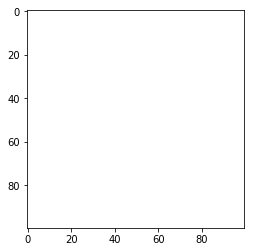

In [10]:
img = torch.zeros((100,100))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get a state of the pendulum

<p align="center">
  <img src="simple_pend.svg" width="250"/>
</p>

In [11]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2

## state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])
print state


 1
 0
[torch.FloatTensor of size 2]



## Convert state of pendulum to line segment

In [12]:
base = torch.FloatTensor([0,0])  # in world coordinates

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50


base_in_img = convert_world_to_img_coordinates(base)


length_x = l * torch.cos(state[0:1])
length_y = l * torch.sin(state[0:1])

length = torch.cat((length_x, length_y))

end = base + length
end_in_img = convert_world_to_img_coordinates(end)

## Find all pixels close enough to line segment


In [13]:
import numpy as np
pi = np.pi

In [14]:
def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]


def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()


 50
 50
[torch.FloatTensor of size 2]


 66.2091
 75.2441
[torch.FloatTensor of size 2]



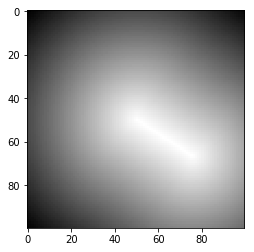

In [15]:
print base_in_img
print end_in_img

img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        img[i,j] = distance_pytorch(base_in_img, end_in_img, this_img_coord)

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Render pendulum

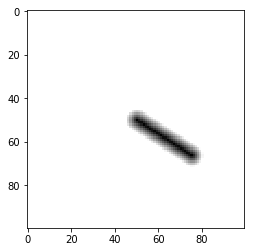

In [16]:
img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        dist = distance_pytorch(base_in_img, end_in_img, this_img_coord)
        if dist < 5.0:
            img[i,j] = 5 - dist

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()


## Get states of pendulum over time

In [39]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg

## state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])

def pendulum_next_state(state, u):
    deriv = torch.zeros(2)
    deriv[0] = state[1]
    deriv[1] = float(-(m * g * l * torch.cos(state[0:1])))
    dt = .01
    next_state = state + deriv*dt
    return next_state

print state
print pendulum_next_state(state,0)
print pendulum_next_state(state,0)
print pendulum_next_state(pendulum_next_state(state,0),0)

state_tape = []
state_tape.append(state)

#for i in range(100):
    



 1
 0
[torch.FloatTensor of size 2]


 1.0000
-1.5885
[torch.FloatTensor of size 2]


 1.0000
-1.5885
[torch.FloatTensor of size 2]


 0.9841
-3.1770
[torch.FloatTensor of size 2]



In [19]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
import glob
import os

def simple_pendulum_deriv(x, t, m, g, l): 
    """The simple pendulum subject to zero damping and zero control input
    Based on material from the MIT OCW subject "Underactuated Robotics"
    "lecture 2: the simple pendulum" given by Russell Tedrake, the 
    maths and some of the related diagrams are given at about 51 minutes
    in.
    """
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = -(m * g * l * np.sin(x[0])) 
    return nx

def plot_orbit( x0 ):
    """Plot the phase space of the pendulum
    """
    # Pick ts to be sufficiently large (by inspection) to make sure
    # that all of the cases of interest will have reached their 
    # homoclinic orbit
    ts = np.linspace(0.0, 50.0, 1001)
    ys = odeint(simple_pendulum_deriv, x0, ts, args = (1.0, 9.8, 1.0))
    plt.plot(ys[:,0], ys[:,1])

def pendulum_video( q0, ts, output_file):
    ts = np.linspace(0.0, 5.0, 101)
    qs = odeint(simple_pendulum_deriv, q0, ts, args = (1.0, 9.8, 1.0))
    pendulum_video_sequence(qs, output_file)

def plot_pendulum(q, length = 1.0):
    xs = [  0.0,  length * np.sin(q[0]) ]
    ys = [  0.0, -length * np.cos(q[0]) ]
    plt.plot( xs, ys, 'b-', linewidth = 3 )
    plt.plot( xs[1], ys[1], 'ro' )
    plt.gca().set_xlim([-1.2, 1.2])
    plt.gca().set_ylim([-1.2, 1.2])
    plt.gca().set_aspect('equal')

def encode_video(input_pattern, output_filename):
    # taken (almost) directly from the matplotlib website:
    # http://matplotlib.sourceforge.net/faq/howto_faq.html#make-a-movie
    os.system("mencoder 'mf://%s' -mf type=png:fps=10 -ovc lavc -lavcopts vcodec")

def pendulum_video_sequence(qs, output_filename):
    for n, q in enumerate(qs):
        print n, q
        plt.clf()
        plot_pendulum( q )
        plt.savefig( '_tmp%03d.png' % n )
    encode_video('_tmp*.png', output_filename)
    for fname in glob.glob('_tmp*.png'):
        os.remove(fname)

def plot_interesting_orbits():
    plt.clf()
    # start with zero velocity at a number of differing angles
    # scipy odeint does some pretty weird things if you have enough
    # velocity to loop around
    plot_orbit(np.array([np.pi * 0.25, 0.0]))
    plot_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_orbit(np.array([np.pi * 0.9, 0.0]))
    plot_orbit(np.array([np.pi * 0.999, 0.0]))
    plt.title('homoclinic orbits for an undamped simpled pendulum')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    plt.show()

def interesting_videos():
    ts = np.linspace(0.0, 50.0, 501)
    pendulum_video( np.array([np.pi/2.0, 0.0]), ts, 'undamped_simple_pendulum01.mp4' )
    pendulum_video( np.array([3*np.pi/4.0, 0.0]), ts, 'undamped_simple_pendulum02.mp4' )
    

